# Formating environemental data

To calculate the mean sequestration time we need to calculate the attenuation of the POC flux which depends on several environemental drivers, notably temperature and oxygen.

This script aims to explore and formate these data to be used easly in the POC attenuation and sequestration time calculation.

In this script we formate the physical data : Temperature and MLD data. Also see the "oxygen_formating" file for oxygen concentration formating.
Also see the "Temperature_MLD_formating" file for temperature and MLD formating. 

## Formating biogeochemical data 

For the oxygen concentrations, we used the "GLOBAL_MULTIYEAR_BGC_001_029" dataset from Copernicus marine data (https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_BGC_001_029/files?subdataset=cmems_mod_glo_bgc_my_0.25_P1M-m_202112&path=GLOBAL_MULTIYEAR_BGC_001_029%2Fcmems_mod_glo_bgc_my_0.25_P1M-m_202112%2F2022%2F ; https://data.marine.copernicus.eu)

The data are described as "The biogeochemical hindcast for global ocean is produced at Mercator-Ocean (Toulouse. France). It provides 3D biogeochemical fields for the time period 1993-2021 at 1/4 degree and on 75 vertical levels. It uses PISCES biogeochemical model (available on the NEMO modelling platform)." 
https://doi.org/10.48670/moi-00019
We downloaded the monthly datasets for summer months (october to March included) for each year available (from 1992 to 2021)
We extracted the molar dissolved oxygen concentration data from this data set.

Then we formated the data the same way as for temperature and MLD: we calculated the monthly climatologies: we average the month over the years, and then we took the average of the summer month in order to have one single dataset that represent the average oxygen concentrtaion in the summer month, over the period from 1993 to 2021.

Then we selected the austral data as the spatial domain from -40°S to -80°S. 

In [1]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import os
import scipy
import math

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


In [3]:
#os.chdir('./Key_Areas_krill_carbon_sequestration/data_envir/Ocean_biogeochemical_month')
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/data_envir/Ocean_biogeochemical_month')

In [4]:
data_oxy = xr.open_mfdataset('mercatorfreebiorys2v4_global_mean_*.nc')['o2']
data_oxy

<xarray.DataArray 'o2' (time: 174, depth: 75, latitude: 681, longitude: 1440)>
dask.array<concatenate, shape=(174, 75, 681, 1440), dtype=float32, chunksize=(1, 75, 681, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * depth      (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2021-12-16T12:00:00
Attributes:
    long_name:      Dissolved Oxygen
    standard_name:  mole_concentration_of_dissolved_molecular_oxygen_in_sea_w...
    units:          mmol m-3
    unit_long:      millimoles of Oxygen per cubic meter
    valid_min:      5.0435874e-06
    valid_max:      440.0899

In [5]:
data_oxy = data_oxy.mean(dim = 'time')
data_oxy

<xarray.DataArray 'o2' (depth: 75, latitude: 681, longitude: 1440)>
dask.array<mean_agg-aggregate, shape=(75, 681, 1440), dtype=float32, chunksize=(75, 681, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * depth      (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03

## Formate 2D spatial grid

The OCIM outputs and the dataset of environmental data are not on the same resolution and their grids are not the same : 
- OCIM output has 91 latitudinal bands, 180 longitudinal bands, the resolution is 2°x2°.
- The physical data has a 0.25°x0.25° resolution.

Thus we interpolate temperature and MLD data over a 2°x2° (2D) spatial grid.

In [6]:
# aggregate on a larger grid of 2°x2° 
data_oxy_coarse = data_oxy.coarsen(latitude=8, longitude=8, boundary="trim").mean()

# interpolate the physcial data
new_lat = np.arange(-79, 90, 2) # create desired latitude and longitude vectors (start at -79 to match the OCIM coords wich are 2°x2° on odd numbers)
new_lon = np.arange(-179, 180, 2) # same for longitude

data_oxy_interpolated = data_oxy_coarse.interp(latitude=new_lat, longitude=new_lon)
data_oxy_interpolated #check OK

<xarray.DataArray 'o2' (depth: 75, latitude: 85, longitude: 180)>
dask.array<chunked_aware_interpnd, shape=(75, 85, 180), dtype=float32, chunksize=(75, 85, 180), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * latitude   (latitude) int32 -79 -77 -75 -73 -71 -69 ... 79 81 83 85 87 89
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179

In [9]:
data_oxy_interpolated.isel(depth=0).plot()

KeyboardInterrupt: 

## Formate depth grid

Regarding depth, the resolution are also different: physical data have 50 depth layers but OCIM has 48 depth layers (and they are not defined on the same intervals). We have to interpolate the T and O2 values at the boudaries of the depth layers of OCIM. 
Indeed, the flux of POC will be calculated at these depth.

In the "fseq_OCIM2_48L" file, we have the middle depth of each layers of the model, but in the "base_data_OCIM2_48L" file we have the upper bound of each layers. Thus we interpolated on the layers boundaries for temperature and oxygen data. 

In [10]:
# load base_data_OCIM2_48L and fseq_OCIM2_48L file to get the depth mid point and boundaries
#os.chdir('./Key_Areas_krill_carbon_sequestration/data_envir')
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/data_envir')

base_data_OCIM2_48L = xr.open_dataset('OCIM2_48L_base_data.nc')
fseq_OCIM2_48L = xr.open_dataset('fseq_OCIM2_48L.nc')

fseq_OCIM2_48L = fseq_OCIM2_48L.assign_coords(longitude = fseq_OCIM2_48L.LON.sel(latitude=0, depth=0),
                                              latitude = fseq_OCIM2_48L.LAT.sel(longitude=0, depth=0), 
                                             depth = fseq_OCIM2_48L.DEPTH.isel(longitude=0, latitude=0))


# Calculate the OCIM boundaries of depth layers:
upper_boudaries = np.unique(np.asarray(base_data_OCIM2_48L['wz']))
upper_boudaries[0] = 0.5058 # use the upper value in the oxygen dataset (otherwise it fills the first layer with zeros)
# we replace the surface value by 0.5058  instead of 0 beacause we don't have the temperature value at depth = 0 (first value at 0.5058 m)

# add the last boudary (sea floor)
last_bottom_boudary = fseq_OCIM2_48L.depth[-1] - (upper_boudaries[-1] - fseq_OCIM2_48L.depth[-1])
layers_depth = np.insert(upper_boudaries, 48, last_bottom_boudary) # insert at last position 
layers_depth

array([5.05800000e-01, 9.86908175e+00, 1.98858758e+01, 3.03458068e+01,
       4.15442995e+01, 5.37767783e+01, 6.73386681e+01, 8.25253934e+01,
       9.96323788e+01, 1.18955049e+02, 1.40788829e+02, 1.65429142e+02,
       1.93171415e+02, 2.24311071e+02, 2.59143535e+02, 2.97964231e+02,
       3.41068585e+02, 3.88752021e+02, 4.41309963e+02, 4.99037836e+02,
       5.62231066e+02, 6.31185076e+02, 7.06195290e+02, 7.87557135e+02,
       8.75566034e+02, 9.70517412e+02, 1.07270669e+03, 1.18242930e+03,
       1.29998067e+03, 1.42565621e+03, 1.55975135e+03, 1.70256152e+03,
       1.85438214e+03, 2.01550864e+03, 2.18623644e+03, 2.36686096e+03,
       2.55767764e+03, 2.75898189e+03, 2.97106913e+03, 3.19423481e+03,
       3.42877433e+03, 3.67498312e+03, 3.93315661e+03, 4.20359023e+03,
       4.48657939e+03, 4.78241952e+03, 5.09140605e+03, 5.41383440e+03,
       5.75000000e+03])

In [11]:
# For the depth interpolation
new_depth = layers_depth
data_oxy_interpolated = data_oxy_interpolated.interp(depth = new_depth)
data_oxy_interpolated

<xarray.DataArray 'o2' (depth: 49, latitude: 85, longitude: 180)>
dask.array<transpose, shape=(49, 85, 180), dtype=float32, chunksize=(49, 85, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) int32 -79 -77 -75 -73 -71 -69 ... 79 81 83 85 87 89
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179
  * depth      (depth) float64 0.5058 9.869 19.89 ... 5.414e+03 5.75e+03

In [12]:
#check with mean temperatue with respect to depth
data_oxy_interpolated.mean(dim=['latitude', 'longitude']).plot()
data_oxy.mean(dim=['latitude', 'longitude']).plot()
# they both look the same = check OK

KeyboardInterrupt: 

### Crop the data to keep the Southern Ocean only

All the data southward than -40°S are selected.

In [13]:
# cut the SO first to have a lighter files when computing the mean (reduce computation time)
data_oxy_SO = data_oxy.sel(latitude=slice(-80, -40))
data_oxy_interpolated_SO = data_oxy_interpolated.sel(latitude=slice(-80, -40))
data_oxy_interpolated_SO

<xarray.DataArray 'o2' (depth: 49, latitude: 20, longitude: 180)>
dask.array<getitem, shape=(49, 20, 180), dtype=float32, chunksize=(49, 20, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) int32 -79 -77 -75 -73 -71 -69 ... -49 -47 -45 -43 -41
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179
  * depth      (depth) float64 0.5058 9.869 19.89 ... 5.414e+03 5.75e+03

In [ ]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.SouthPolarStereo()

p = data_oxy_interpolated_SO.mean(dim = 'depth').plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    #cmap="PuBu",
    #title = 'mean time of carbon sequesration'
)  # the plot's projection

#p.axes.coastlines()
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'mean [O2]', shrink = 0.8)
plt.title('Map of the mean oxygen concentrations across depth [mmol m-3]')

Text(0.5, 1.0, 'Map of the mean oxygen concentrations across depth [mmol m-3]')

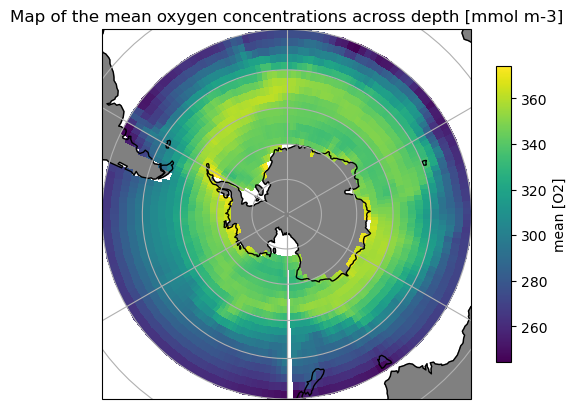

In [17]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.SouthPolarStereo()

p = data_oxy_interpolated_SO.isel(depth=0).plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
)  

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'mean [O2]', shrink = 0.8)
plt.title('Map of the mean oxygen concentrations across depth [mmol m-3]')

### Summary of the formated files available in this script
- summer average with 2° x 2° resolution and the 48 ocim depth bands, Southern ocean (from -40°) = **data_oxy_interpolated_SO**

In [16]:
# Save files
## for now save only thetao and MLD interpolated SO (the file we use in the POC attenuation calculation)
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/data_envir/Ocean_biogeochemical_month')
data_oxy_interpolated_SO.to_netcdf('oxygen_summer_SO_interpolated.nc')
